In [1]:
import ipywidgets
import umap.umap_ as umap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score, adjusted_rand_score
import seaborn as sns
import os
from ipywidgets import interact
from matplotlib.widgets import Slider
from umap import UMAP

# Part 1: Supervised Learning
## 1a. Data Loading and Cleaning

In [8]:
# load from subfolder relative to current directory and drop missing

trainX = pd.read_csv('train.csv')
testX = pd.read_csv('test.csv')
trainY = pd.read_csv('train_short_labels.csv')
testY = pd.read_csv('test_short_labels.csv')
blindX = pd.read_csv('blind_test.csv')

# versions of the dataframes without missing values. In other situations we want to keep the existence of the rows in order to do the 
# movmean properly, or else delete the whole chunk (unnecessary)
trainX_nn = trainX.dropna()
testX_nn = testX.dropna()
trainY_nn = trainY.dropna()
testY_nn = testY.dropna()
blindX_nn = blindX.dropna()
    
# get regular matrix copies because i'm a neanderthal 
trainX_m = trainX_nn.to_numpy()
testX_m = testX_nn.to_numpy()
trainY_m = trainY_nn.to_numpy()
testY_m = testY_nn.to_numpy()
blindX_m = blindX_nn.to_numpy()

# 150 row chunks

## 1b. Calculating Area

In [ ]:
# Area as a measure of outlier-ness and as a feature

import scipy.spatial
from scipy.spatial import ConvexHull

def getAreas(matrix):
    area = np.zeros((len(matrix), 2))

    for i in range(0,len(matrix)):
        temp = np.hsplit(matrix[i,1:27], 2)
        temp = np.transpose(temp)
        area[i, 0] = ConvexHull(temp).area

        temp = np.hsplit(matrix[i,27:53], 2)
        temp = np.transpose(temp)
        area[i, 1] = ConvexHull(temp).area

    return area

trainX_area = getAreas(trainX_m)
testX_area = getAreas(testX_m)
blindX_area = getAreas(blindX_m)

Text(321.26767676767673, 0.5, 'Data Col')

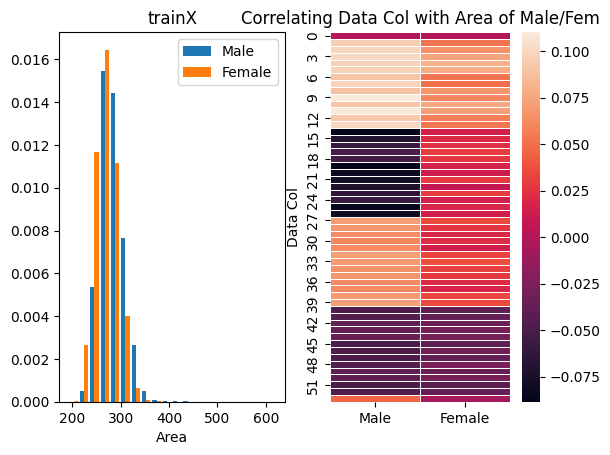

In [41]:
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns

plt.subplot(1, 2, 1)
plt.hist(trainX_area, 20, label=["Male", "Female"], density=True)
plt.legend()
plt.title("trainX")
plt.xlabel("Area")

tx_corr = np.zeros([np.size(trainX_m, 1),2])

for i in range(0, 2):
    for j in range(1, np.size(trainX_m, 1)):
        tx_corr[j, i] = scipy.stats.spearmanr(trainX_area[:, i], trainX_m[:, j]).statistic

plt.subplot(1, 2, 2)
sns.heatmap(tx_corr, linewidth=0.5, xticklabels=["Male", "Female"])
plt.title("Correlating Data Col with Area of Male/Fem")
plt.ylabel("Data Col")


#scipy.stats.wilcoxon(area)


Text(321.26767676767673, 0.5, 'Data Col')

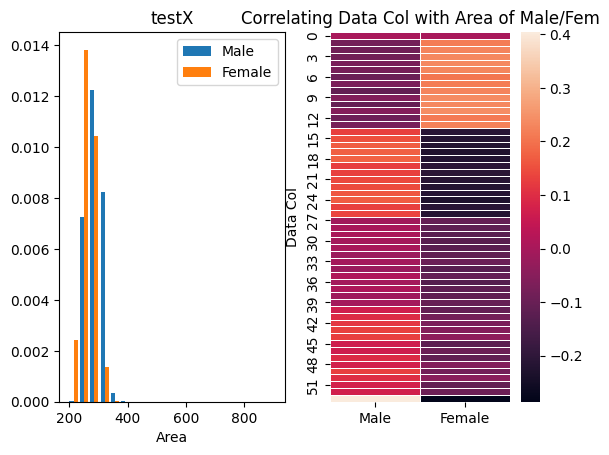

In [ ]:
plt.subplot(1, 2, 1)
plt.hist(testX_area, 20, label=["Male", "Female"], density=True)
plt.legend()
plt.title("Dist of Area in testX Data")
plt.xlabel("Area")

tstx_corr = np.zeros([np.size(testX_m, 1),2])

for i in range(0, 2):
    for j in range(1, np.size(testX_m, 1)):
        tstx_corr[j, i] = scipy.stats.spearmanr(testX_area[:, i], testX_m[:, j]).statistic

plt.subplot(1, 2, 2)
sns.heatmap(tstx_corr, linewidth=0.5, xticklabels=["Male", "Female"])
plt.title("Correlating Data Col with Area of Male/Fem")
plt.ylabel("Data Col")


Text(321.26767676767673, 0.5, 'Data Col')

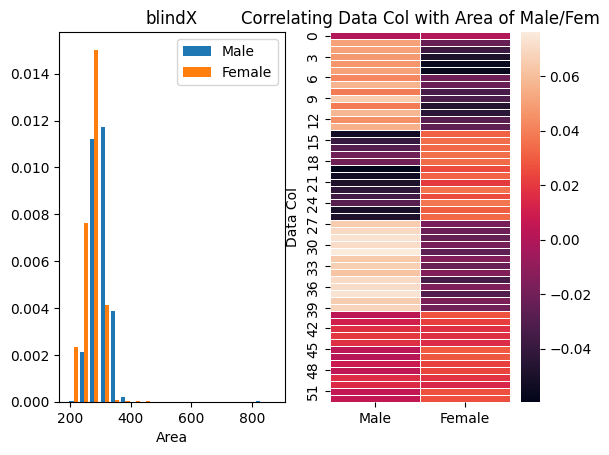

In [ ]:
plt.subplot(1, 2, 1)
plt.hist(blindX_area, 20, label=["Male", "Female"], density=True)
plt.legend()
plt.title("blindX")
plt.xlabel("Area")

bx_corr = np.zeros([np.size(blindX_m, 1),2])

for i in range(0, 2):
    for j in range(1, np.size(blindX_m, 1)):
        bx_corr[j, i] = scipy.stats.spearmanr(blindX_area[:, i], blindX_m[:, j]).statistic

plt.subplot(1, 2, 2)
sns.heatmap(bx_corr, linewidth=0.5, xticklabels=["Male", "Female"])
plt.title("Correlating Data Col with Area of Male/Fem")
plt.ylabel("Data Col")


# 2. Creating Features

## 2a. speed (temporal)


In [ ]:
#print(windowSize.value)
from scipy.spatial import distance
import statistics

def getSpeed(matrix):
    numRows = np.size(matrix, 0)
    s50_m = np.zeros([numRows,]) * np.nan
    s25_m = np.zeros([numRows,]) * np.nan
    s15_m = np.zeros([numRows,]) * np.nan

    s50_f = np.zeros([numRows,]) * np.nan
    s25_f = np.zeros([numRows,]) * np.nan
    s15_f = np.zeros([numRows,]) * np.nan

    # for every 150 frame chunk
    for i in range(0, np.size(matrix, 0), 150):
        temp = matrix[i:i+150, :]
        currentChunk = round(i/150)

        # window size 50
        for j in range(0, 101):
            s50_m[(150*currentChunk)+j] = np.linalg.norm(temp[j,[2,15]] - temp[j+49,[2,15]])
            s50_f[(150*currentChunk)+j] = np.linalg.norm(temp[j,[28,41]] - temp[j+49,[28,41]])

        # window size 25
        for j in range(0, 126):
            s25_m[(150*currentChunk)+j] = np.linalg.norm(temp[j,[2,15]] - temp[j+24,[2,15]])
            s25_f[(150*currentChunk)+j] = np.linalg.norm(temp[j,[28,41]] - temp[j+24,[28,41]])
        
        # window size 15
        for j in range(0, 136):
            s15_m[(150*currentChunk)+j] = np.linalg.norm(temp[j,[2,15]] - temp[j+14,[2,15]])
            s15_f[(150*currentChunk)+j] = np.linalg.norm(temp[j,[28,41]] - temp[j+14,[28,41]]) 

    maleRes = np.column_stack((s50_m, s25_m, s15_m))
    femRes = np.column_stack((s50_f, s25_f, s15_f))
    return(np.column_stack((maleRes, femRes)))


trainSpeed = getSpeed(trainX_m)
testSpeed = getSpeed(testX_m)
blindSpeed = getSpeed(blindX_m)

(0.0, 0.15)

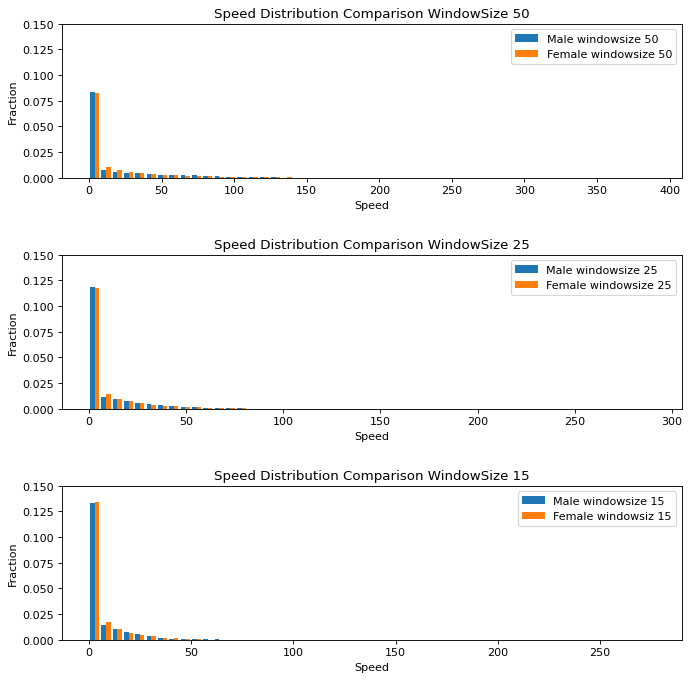

In [245]:
fig = plt.figure(figsize=(10,10), dpi=80)
gs = fig.add_gridspec(3, 1, hspace=.5, wspace=.5)

ax = gs.subplots()

ax[0].hist(trainSpeed[:,[0,3]], 50, label=["Male windowsize 50", "Female windowsize 50"], density=True)
ax[0].legend()
ax[0].set_title("Speed Distribution Comparison WindowSize 50")
ax[0].set_xlabel("Speed")
ax[0].set_ylabel("Fraction")
ax[0].set_ylim([0, .15])

#plt.subplot(3, 1, 2)
ax[1].hist(trainSpeed[:,[1,4]], 50, label=["Male windowsize 25", "Female windowsize 25"], density=True)
ax[1].legend()
ax[1].set_title("Speed Distribution Comparison WindowSize 25")
ax[1].set_xlabel("Speed")
ax[1].set_ylabel("Fraction")
ax[1].set_ylim([0, .15])

#plt.subplot(3, 1, 3)
ax[2].hist(trainSpeed[:,[2,5]], 50, label=["Male windowsize 15", "Female windowsiz 15"], density=True)
ax[2].legend()
ax[2].set_title("Speed Distribution Comparison WindowSize 15")
ax[2].set_xlabel("Speed")
ax[2].set_ylabel("Fraction")
ax[2].set_ylim([0, .15])

In [239]:
# Correlating Male and Female Fly Speed, Across the 3 window sizes, in order of 50, 25 and 15

print(scipy.stats.spearmanr(trainSpeed[:,0], trainSpeed[:,3], nan_policy='omit'))
print(scipy.stats.spearmanr(trainSpeed[:,1], trainSpeed[:,4], nan_policy='omit'))
print(scipy.stats.spearmanr(trainSpeed[:,2], trainSpeed[:,5], nan_policy='omit'))

SignificanceResult(statistic=0.6160891175311863, pvalue=0.0)
SignificanceResult(statistic=0.5611847433774975, pvalue=0.0)
SignificanceResult(statistic=0.5199052627824282, pvalue=0.0)


## 2b. wingspan

In [250]:
def getWingSpan(matrix):

    numRows = np.size(matrix, 0)
    wingspan_res = np.zeros([numRows, 2])

    for i in range(0, numRows):
        wingspan_res[i, 0] = np.linalg.norm(matrix[i,[4,17]] - matrix[i,[5,18]])
        wingspan_res[i, 1] = np.linalg.norm(matrix[i,[30,43]] - matrix[i,[31,44]])

    return wingspan_res

trainWS = getWingSpan(trainX_m)
testWS = getWingSpan(testX_m)
blindWS = getWingSpan(blindX_m)

## 2c. distance between conspecifics


In [251]:
def getDistance(matrix):    
    numRows = np.size(matrix, 0)
    dist_res = np.zeros([numRows,])

    for i in range(0, numRows):
        dist_res[i,] = np.linalg.norm(matrix[i,[2,15]] - matrix[i,[28,41]])

    return dist_res

trainDist = getDistance(trainX_m)
testDist = getDistance(testX_m)
blindDist = getDistance(blindX_m)

## 2d. Max Wing Speed

In [252]:
def getWingSpeed(matrix):
    numRows = np.size(matrix, 0)
    s50_m = np.zeros([numRows,]) * np.nan
    s25_m = np.zeros([numRows,]) * np.nan
    s15_m = np.zeros([numRows,]) * np.nan

    s50_f = np.zeros([numRows,]) * np.nan
    s25_f = np.zeros([numRows,]) * np.nan
    s15_f = np.zeros([numRows,]) * np.nan

    # for every 150 frame chunk
    for i in range(0, np.size(matrix, 0), 150):
        temp = matrix[i:i+150, :]
        currentChunk = round(i/150)

        # window size 50
        for j in range(0, 101):
            s50_m[(150*currentChunk)+j] = np.max([np.linalg.norm(temp[j,[4,17]] - temp[j+49,[4,17]]), np.linalg.norm(temp[j,[5,18]] - temp[j+49,[5,18]])])
            s50_f[(150*currentChunk)+j] = np.max([np.linalg.norm(temp[j,[30,43]] - temp[j+49,[30,43]]), np.linalg.norm(temp[j,[31,44]] - temp[j+49,[31,44]])])

        # window size 25
        for j in range(0, 126):
            s25_m[(150*currentChunk)+j] = np.max([np.linalg.norm(temp[j,[4,17]] - temp[j+24,[4,17]]), np.linalg.norm(temp[j,[5,18]] - temp[j+24,[5,18]])])
            s25_f[(150*currentChunk)+j] = np.max([np.linalg.norm(temp[j,[30,43]] - temp[j+24,[30,43]]), np.linalg.norm(temp[j,[31,44]] - temp[j+24,[31,44]])])
        
        # window size 15
        for j in range(0, 136):
            s15_m[(150*currentChunk)+j] = np.max([np.linalg.norm(temp[j,[4,17]] - temp[j+14,[4,17]]), np.linalg.norm(temp[j,[5,18]] - temp[j+14,[5,18]])])
            s15_f[(150*currentChunk)+j] = np.max([np.linalg.norm(temp[j,[30,43]] - temp[j+14,[30,43]]), np.linalg.norm(temp[j,[31,44]] - temp[j+14,[31,44]])]) 

    maleRes = np.column_stack((s50_m, s25_m, s15_m))
    femRes = np.column_stack((s50_f, s25_f, s15_f))
    return(np.column_stack((maleRes, femRes)))


trainWingSpeed = getWingSpeed(trainX_m)
testWingSpeed = getWingSpeed(testX_m)
blindWingSpeed = getWingSpeed(blindX_m)

(0.0, 0.13)

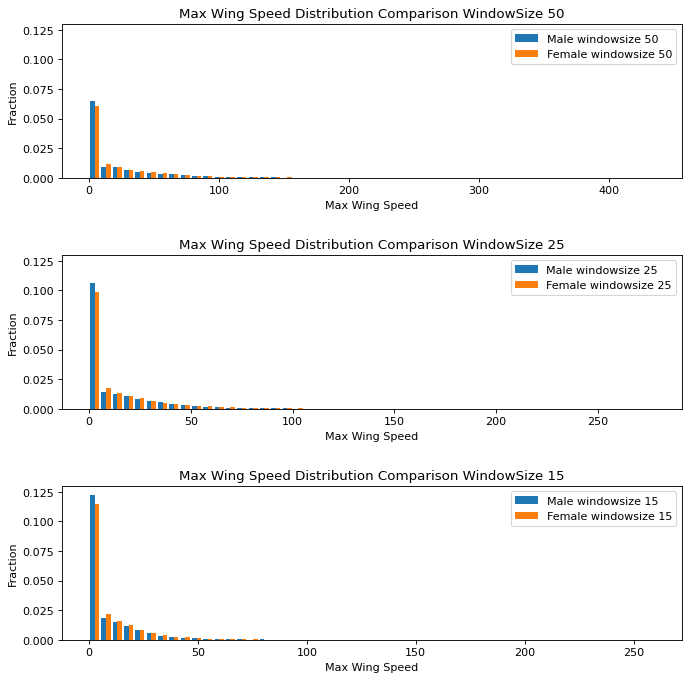

In [249]:
fig = plt.figure(figsize=(10,10), dpi=80)
gs = fig.add_gridspec(3, 1, hspace=.5, wspace=.5)

ax = gs.subplots()

ax[0].hist(trainWingSpeed[:,[0,3]], 50, label=["Male windowsize 50", "Female windowsize 50"], density=True)
ax[0].legend()
ax[0].set_title("Max Wing Speed Distribution Comparison WindowSize 50")
ax[0].set_xlabel("Max Wing Speed")
ax[0].set_ylabel("Fraction")
ax[0].set_ylim([0, .13])

#plt.subplot(3, 1, 2)
ax[1].hist(trainWingSpeed[:,[1,4]], 50, label=["Male windowsize 25", "Female windowsize 25"], density=True)
ax[1].legend()
ax[1].set_title("Max Wing Speed Distribution Comparison WindowSize 25")
ax[1].set_xlabel("Max Wing Speed")
ax[1].set_ylabel("Fraction")
ax[1].set_ylim([0, .13])

#plt.subplot(3, 1, 3)
ax[2].hist(trainWingSpeed[:,[2,5]], 50, label=["Male windowsize 15", "Female windowsize 15"], density=True)
ax[2].legend()
ax[2].set_title("Max Wing Speed Distribution Comparison WindowSize 15")
ax[2].set_xlabel("Max Wing Speed")
ax[2].set_ylabel("Fraction")
ax[2].set_ylim([0, .13])

## 2e. Bringing Together All Features

In [304]:
import ipywidgets as widgets

windowSize = widgets.ToggleButtons(
    options=[15, 25, 50],
    description='Window Size:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Smaller Window', 'Larger Window', 'Largest Window'],
#     icons=['check'] * 3
)
windowSize

ToggleButtons(description='Window Size:', options=(15, 25, 50), tooltips=('Smaller Window', 'Larger Window', '…

In [305]:
if windowSize.value == 15:
    indSel = [2,5]
elif windowSize.value == 25:
    indSel = [1,4]
else:
    indSel = [0,3]

d = np.column_stack((trainX_area, trainSpeed[:,indSel], trainWS, trainDist, trainWingSpeed[:,indSel], trainX_m[:,53]))
columns = ["Area M", "Area F", "Speed M", "Speed F", "Wingspan M", "Wingspan F", "Distance", "Max Wing Speed M", "Max Wing Speed F", "label"]
trainDF = pd.DataFrame(data=d, columns=columns)

d = np.column_stack((testX_area, testSpeed[:,indSel], testWS, testDist, testWingSpeed[:,indSel], testX_m[:,53]))
columns = ["Area M", "Area F", "Speed M", "Speed F", "Wingspan M", "Wingspan F", "Distance", "Max Wing Speed M", "Max Wing Speed F", "label"]
testDF = pd.DataFrame(data=d, columns=columns)

d = np.column_stack((blindX_area, blindSpeed[:,indSel], blindWS, blindDist, blindWingSpeed[:,indSel]))
columns = ["Area M", "Area F", "Speed M", "Speed F", "Wingspan M", "Wingspan F", "Distance", "Max Wing Speed M", "Max Wing Speed F"]
blindDF = pd.DataFrame(data=d, columns=columns)

# 3 Visual Testing of Features

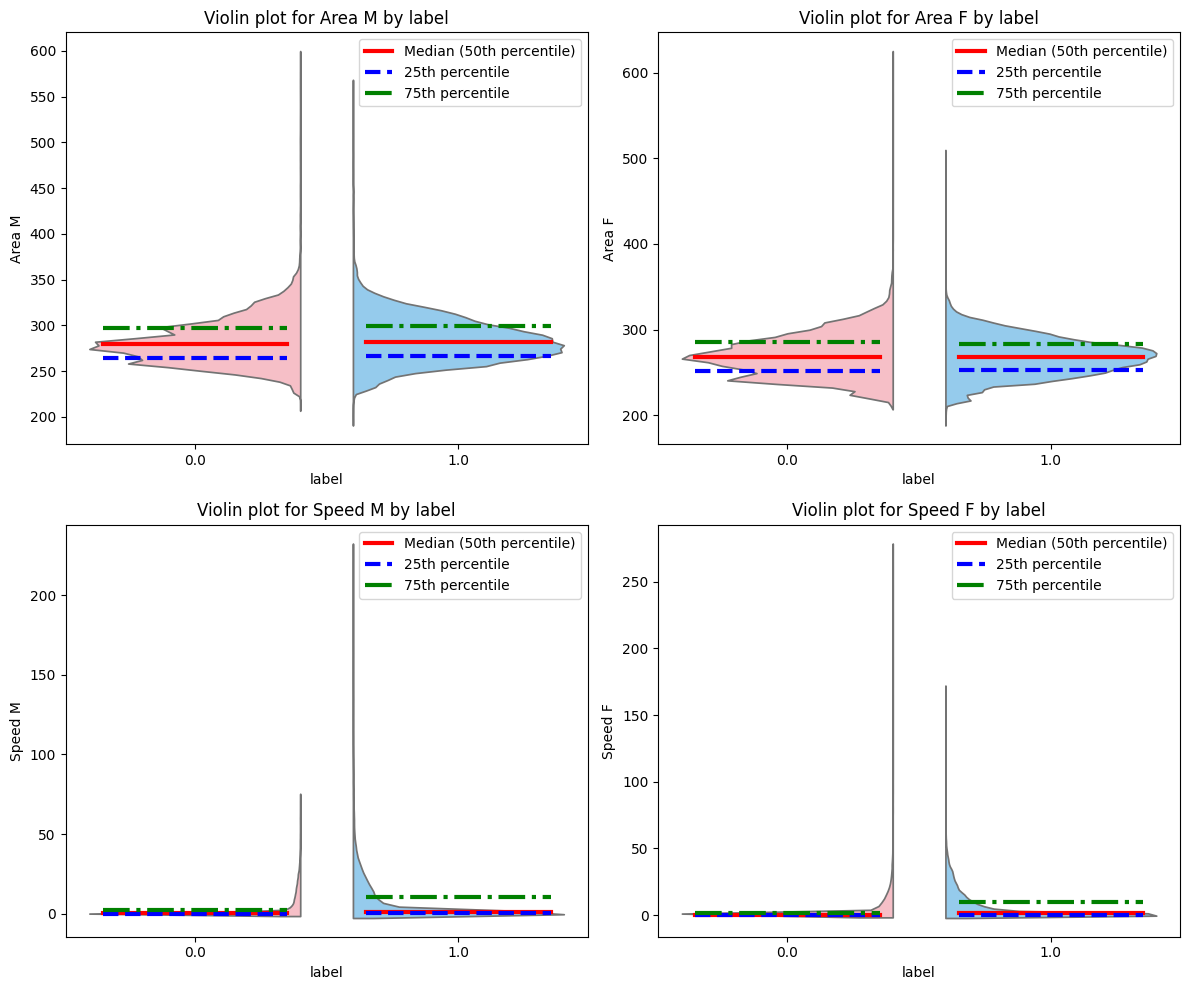

In [306]:
def plot_violin_with_statistics(df, col1, col2, col3, col4):
    # Assuming the label column is named 'label'
    label_column = 'label'

    # The selected feature columns
    feature_columns = [col1, col2, col3, col4]

    # Set up the 2x2 plotting area
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

    # Flatten axes array for easier indexing
    axes = axes.flatten()

    # Define the colors for the violin plots
    palette = {0: "lightpink", 1: "lightskyblue"}

    # Plot each feature in the specified columns
    for i, feature in enumerate(feature_columns):
        sns.violinplot(x=label_column, y=feature, data=df, ax=axes[i], split=True, inner=None, hue=label_column, palette=palette, legend=False)

        # Overlay median, 25th percentile, and 75th percentile for both labels
        for label_value in df[label_column].unique():
            subset = df[df[label_column] == label_value][feature]
            median = subset.median()
            q25 = subset.quantile(0.25)
            q75 = subset.quantile(0.75)

            # Adjusting the plotting positions for better visibility
            axes[i].plot([label_value - 0.35, label_value + 0.35], [median, median], color='red', linestyle='-', linewidth=3)
            axes[i].plot([label_value - 0.35, label_value + 0.35], [q25, q25], color='blue', linestyle='--', linewidth=3)
            axes[i].plot([label_value - 0.35, label_value + 0.35], [q75, q75], color='green', linestyle='-.', linewidth=3)

        # Set the title and labels
        axes[i].set_title(f'Violin plot for {feature} by {label_column}')

        # Adding a custom legend for the percentiles to each subplot
        lines = [plt.Line2D([0], [0], color='red', linestyle='-', linewidth=3),
                 plt.Line2D([0], [0], color='blue', linestyle='--', linewidth=3),
                 plt.Line2D([0], [0], color='green', linestyle='-.', linewidth=3)]
        labels = ['Median (50th percentile)', '25th percentile', '75th percentile']
        axes[i].legend(lines, labels, loc='upper right')

    # Adjust layout for better readability
    plt.tight_layout()
    plt.show()

plot_violin_with_statistics(trainDF,'Area M','Area F','Speed M','Speed F')

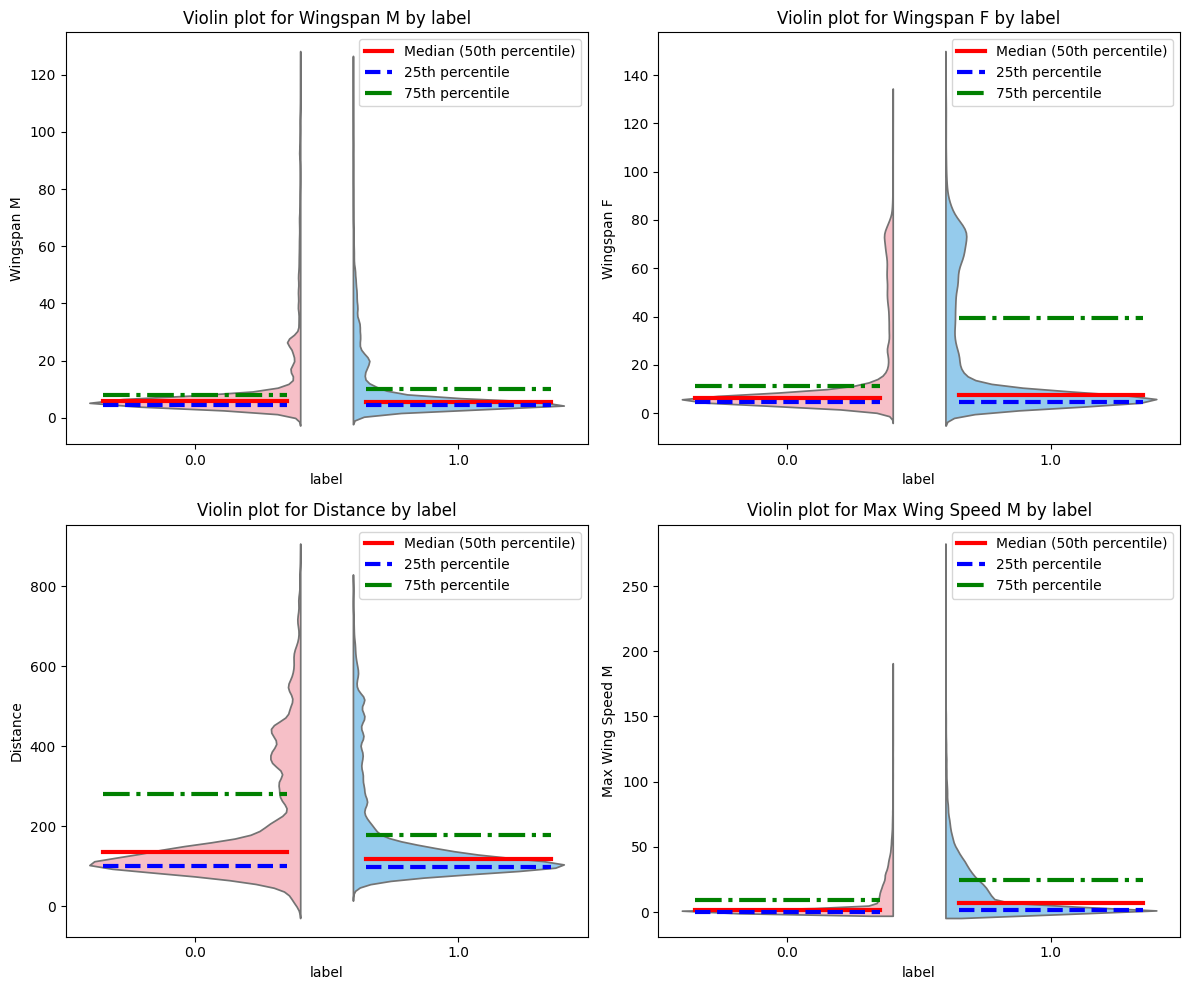

In [293]:
plot_violin_with_statistics(trainDF,"Wingspan M", "Wingspan F", "Distance", "Max Wing Speed M")

## 3b. Which Features are better predictors?
I believe that distance, max wing speed, wing span F and speed will be good predictors for the labels. As the plots show, they demonstrate quantitative differences in their distributions across the labels, thus implying a predictive power in the training set. If the testing and blind data is similar to the training data, then this power is likely to be useful there too.

# 4 Train and Evaluate Models on Training Set with 80/20 Split
## 4a. Random Forest

In [309]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def build_and_train_rf(df, n_estimators=100, max_depth=None, test_size=0.2, random_state=None):
    # Separate features and labels
    X = df.iloc[:, :-1]  # First 25 columns are features
    y = df.iloc[:, -1]   # Last column is the label

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Feature scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Initialize and train the Random Forest model
    rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    rf_model.fit(X_train, y_train)

    # Make predictions
    y_pred = rf_model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Generate and display the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix using seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Print accuracy and classification report
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", report)

    return rf_model, scaler 

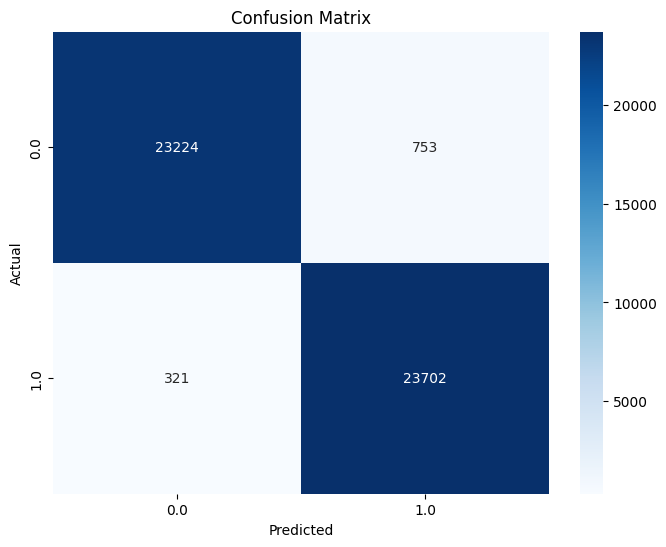

Accuracy: 0.9776
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.97      0.98     23977
         1.0       0.97      0.99      0.98     24023

    accuracy                           0.98     48000
   macro avg       0.98      0.98      0.98     48000
weighted avg       0.98      0.98      0.98     48000



In [310]:
rf_model, scaler = build_and_train_rf(trainDF, n_estimators=100, max_depth=None, test_size=0.2, random_state=1004)

## 4b. Neural Network

In [315]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network  import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt

def build_and_train_nn_adam(train_df, test_size, alpha, activation='tanh', hiddenLayerSizes=(10,10,10),random_state=None):
    # Separate features and labels
    X = train_df.iloc[:, :-1]  # All columns except the last are features
    y = train_df.iloc[:, -1]   # Last column is the label

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Feature scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Feature scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Initialize and train the Neural Network model
    #clf = MLPClassifier(solver='adam', alpha=regTerm, activation=activation, hidden_layer_sizes=hiddenLayerSizes, max_iter=20, random_state=1, early_stopping=True, validation_fraction=.1)
    clf = MLPClassifier(activation=activation, alpha=alpha, hidden_layer_sizes=hiddenLayerSizes, random_state=random_state)
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Generate and display the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Print accuracy and classification report
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", report)

    return rf_model, scaler

f:\NatBehFinalProj\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


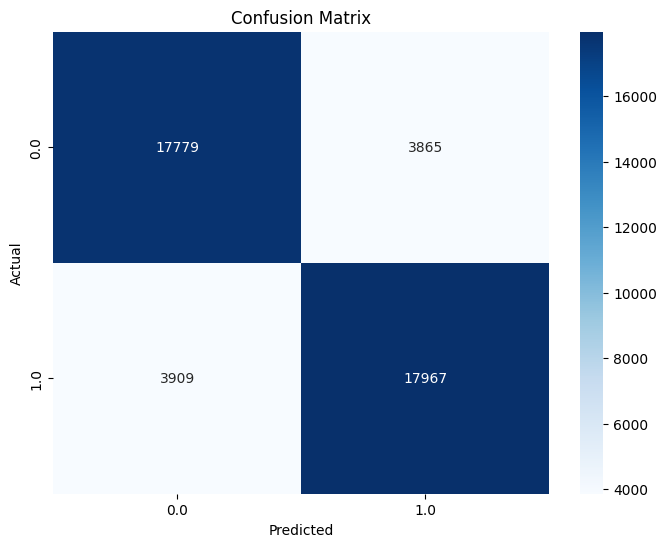

Accuracy: 0.8214
Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.82      0.82     21644
         1.0       0.82      0.82      0.82     21876

    accuracy                           0.82     43520
   macro avg       0.82      0.82      0.82     43520
weighted avg       0.82      0.82      0.82     43520



In [316]:
rf_model, scaler = build_and_train_nn_adam(trainDF.dropna(), .2, 1e-3, activation='tanh', hiddenLayerSizes=(10,10,10))

# 5 Train and Evaluate Models On Training Set and Test Data
## 5a. Random Forest

In [308]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def build_and_train_rf_with_test(train_df, test_df, n_estimators=100, max_depth=None, random_state=None):
    # Separate features and labels for training data
    X_train = train_df.iloc[:, :-1]  # All columns except the last are features
    y_train = train_df.iloc[:, -1]   # The last column is the label

    # Separate features and labels for testing data
    X_test = test_df.iloc[:, :-1]
    y_test = test_df.iloc[:, -1]

    # Feature scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Initialize and train the Random Forest model
    rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    rf_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = rf_model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Generate and display the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Print accuracy and classification report
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", report)

    return rf_model, scaler  # Return both the model and the scaler

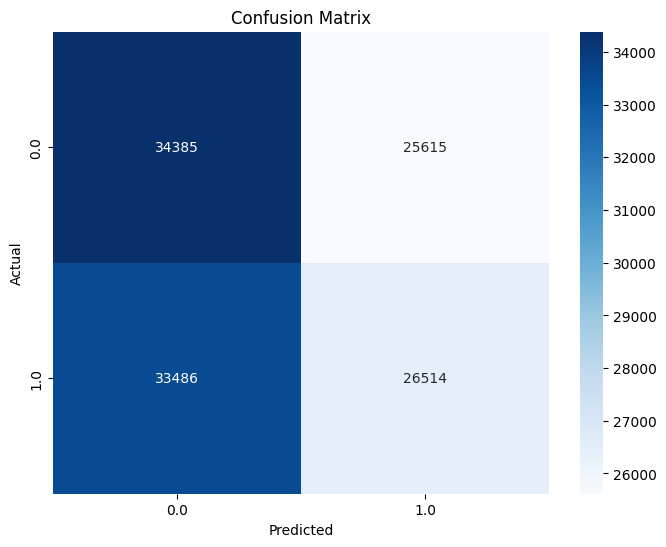

Accuracy: 0.5075
Classification Report:
               precision    recall  f1-score   support

         0.0       0.51      0.57      0.54     60000
         1.0       0.51      0.44      0.47     60000

    accuracy                           0.51    120000
   macro avg       0.51      0.51      0.51    120000
weighted avg       0.51      0.51      0.51    120000



In [ ]:
rf_model, scaler = build_and_train_rf_with_test(trainDF, testDF, n_estimators=150, max_depth=None)

## 5b. Neural Network

In [ ]:
def build_and_train_nn_adam_with_test(train_df, test_df, alpha, activation='tanh', hiddenLayerSizes=(10,10,10),random_state=None):
    # Separate features and labels for training data
    X_train = train_df.iloc[:, :-1]  # All columns except the last are features
    y_train = train_df.iloc[:, -1]   # The last column is the label

    # Separate features and labels for testing data
    X_test = test_df.iloc[:, :-1]
    y_test = test_df.iloc[:, -1]

    # Feature scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Initialize and train the Neural Network model
    #clf = MLPClassifier(solver='adam', alpha=regTerm, activation=activation, hidden_layer_sizes=hiddenLayerSizes, max_iter=20, random_state=1, early_stopping=True, validation_fraction=.1)
    clf = MLPClassifier(activation=activation, alpha=alpha, hidden_layer_sizes=hiddenLayerSizes, random_state=random_state)
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Generate and display the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Print accuracy and classification report
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", report)

    return rf_model, scaler

f:\NatBehFinalProj\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


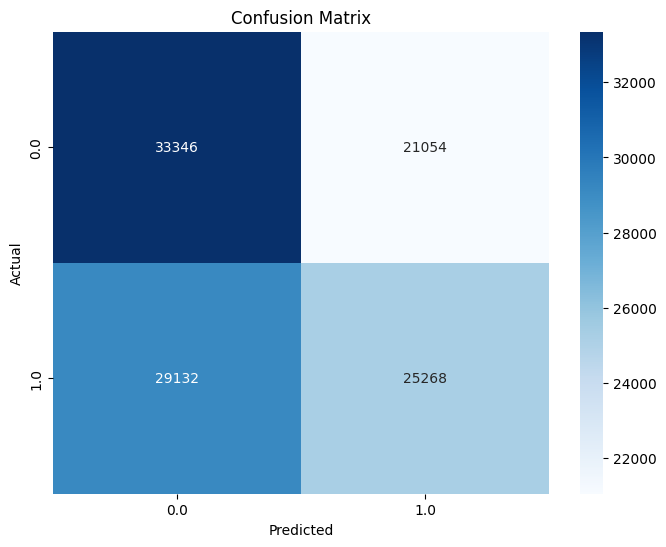

Accuracy: 0.5387
Classification Report:
               precision    recall  f1-score   support

         0.0       0.53      0.61      0.57     54400
         1.0       0.55      0.46      0.50     54400

    accuracy                           0.54    108800
   macro avg       0.54      0.54      0.54    108800
weighted avg       0.54      0.54      0.54    108800



In [314]:
rf_model, scaler = build_and_train_nn_adam_with_test(trainDF.dropna(), testDF.dropna(), 1e-3, activation='tanh', hiddenLayerSizes=(10,10,10))

## 5c. Comparing 4 and 5 Results
Splitting the training set gave better results than training and testing on different sets. This could be due to differences in the data between the two sets, i.e. they are not homogenous enough. The flies could be at different stages in their courtship or time of day. It depends on what the label means, I do not know.

# 6 Enhanced Preprocessing
## 6a. Preprocessing Step

In [327]:
trainPP = trainDF.groupby(np.arange(len(trainDF))//150).mean()
trainPP['label'] = trainY['labels'].values

testPP = testDF.groupby(np.arange(len(testDF))//150).mean()
testPP['label'] = testY['labels'].values

blindPP = blindDF.groupby(np.arange(len(blindDF))//150).mean()

## 6b. Random Forest

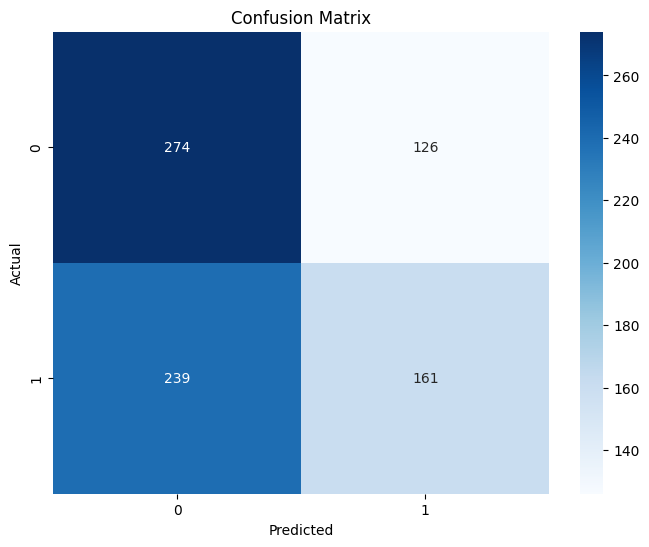

Accuracy: 0.5437
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.69      0.60       400
           1       0.56      0.40      0.47       400

    accuracy                           0.54       800
   macro avg       0.55      0.54      0.53       800
weighted avg       0.55      0.54      0.53       800



In [330]:
rf_model, scaler = build_and_train_rf_with_test(trainPP, testPP, n_estimators=150, max_depth=None)

## 6c. Neural Network

f:\NatBehFinalProj\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


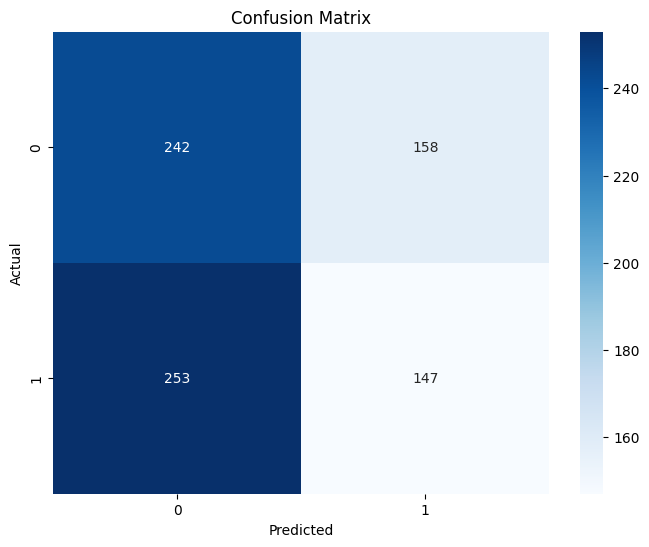

Accuracy: 0.4863
Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.60      0.54       400
           1       0.48      0.37      0.42       400

    accuracy                           0.49       800
   macro avg       0.49      0.49      0.48       800
weighted avg       0.49      0.49      0.48       800



In [331]:
rf_model, scaler = build_and_train_nn_adam_with_test(trainPP.dropna(), testPP.dropna(), 1e-3, activation='tanh', hiddenLayerSizes=(10,10,10))

# 7 Blind Test Prediction with Random Forest

In [338]:
def build_and_train_rf_blind(train_df, test_df, n_estimators=100, max_depth=None, random_state=None):
    # Separate features and labels for training data
    X_train = train_df.iloc[:, :-1]  # All columns except the last are features
    y_train = train_df.iloc[:, -1]   # The last column is the label

    # Separate features and labels for testing data
    X_test = test_df

    # Feature scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Initialize and train the Random Forest model
    rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    rf_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = rf_model.predict(X_test)

    return y_pred  # Return both the model and the scaler

y_pred = build_and_train_rf_blind(pd.concat([trainPP, testPP], ignore_index=True), blindPP, n_estimators=150, max_depth=None)

blindPredDF = pd.DataFrame(data=y_pred, columns=["labels"])
blindPredDF.to_csv('blind_prediction.csv', index=True)
